In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [178]:
def shuffle_examples(X,y):
  p = np.random.permutation(len(X))
  return X[p],y[p]

def split_train_validation_test(X,y,p_t,p_tv):
  n = int(p_t*len(X))
  m = int(p_tv*len(X))
  return X[:n],y[:n],X[n:m],y[n:m],X[m:],y[m:]   

def scale(x):
  mu = np.mean(x,axis=0)
  st = np.std(x,axis=0)
  return (x-mu)/st,mu,st  

def sigmoid(x):
  return 1/(1+np.exp(-x))

def relu(x):
  return np.maximum(0,x)  

def sigmoid_p(x):
  return sigmoid(x)*(1-sigmoid(x))

def relu_p(x):
  return 1*(x >= 0)    

def error(y,y_hat):
  return -np.sum(y*np.log(y_hat)+(1-y)*np.log(1-y_hat))/len(y)

def error_reg(y,y_hat,W,la):
  J_reg = -np.sum(y*np.log(y_hat)+(1-y)*np.log(1-y_hat))/len(y)
  for l in range(1,len(W)):
    J_reg = J_reg + la*np.sum(W[l]**2)/len(y)
  return J_reg      

def accuracy_recall_precision(y_hat,y):
  y_hat_cat = 1*(y_hat > 0.5)
  correct_predictions = np.sum(y_hat_cat == y)
  predictions = len(y)
  true_positives = np.sum((y_hat_cat == 1) & (y == 1))
  positives = np.sum(y)
  predicted_positives = np.sum(y_hat_cat)
  accuracy = correct_predictions/predictions
  recall = true_positives/positives
  precision = true_positives/predicted_positives
  return accuracy, recall, precision  

def h(x,act):
  if act == 'sigmoid':
    return sigmoid(x)
  if act == 'relu':
    return relu(x)
  if act == 'identity':
    return x
  if act == 'tanh':
    return np.tanh(x)
  return 'Problem' 

def h_p(x,act):
  if act == 'sigmoid':
    return sigmoid_p(x)
  if act == 'relu':
    return relu_p(x)
  if act == 'identity':
    return 1
  if act == 'tanh':
    return 1/(np.cosh(x))**2
  return 'Problem'  

def As_Zs(X,W,b,act):
  A = [X]
  Z = [0]
  for l in range(1,len(b)):
    Z.append(np.matmul(A[-1],W[l])+b[l])
    A.append(h(Z[-1],act[l]))
  return A,Z 

def gradients(A,Z,act,W,y):
  y_hat = A[-1]
  l = len(W)-1
  DJ_DW = []
  DJ_Db = []
  DJ_DZ = (y_hat - y.reshape(-1,1))/len(y)
  while l > 1:
    DJ_DA = np.matmul(DJ_DZ,W[l].T)
    DJ_DW.insert(0,np.matmul(A[l-1].T,DJ_DZ)) 
    DJ_Db.insert(0,np.sum(DJ_DZ,axis=0))
    DJ_DZ = DJ_DA*h_p(Z[l-1],act[l-1])
    l = l-1
  DJ_DA = np.matmul(DJ_DZ,W[1].T)
  DJ_DW.insert(0,np.matmul(A[0].T,DJ_DZ)) 
  DJ_Db.insert(0,np.sum(DJ_DZ,axis=0)) 
  DJ_DW.insert(0,0) 
  DJ_Db.insert(0,0)  
  return DJ_DW,DJ_Db  

def update_parameters(W,b,DJ_DW,DJ_Db,c):
  for l in range(1,len(b)):
    W[l] = W[l] - c*DJ_DW[l]
    b[l] = b[l] - c*DJ_Db[l]
  return W, b  

def update_parameters_reg(W,b,DJ_DW,DJ_Db,c,m,la):
  for l in range(1,len(b)):
    W[l] = W[l] - c*DJ_DW[l] - 2*c*la*W[l]/m
    b[l] = b[l] - c*DJ_Db[l] 
  return W, b  

def initialize_W_and_b(n):
  W = [0]
  b = [0]
  for l in range(1,len(n)):
    W.append(np.random.randn(n[l-1],n[l])/np.sqrt(n[l-1]))
    b.append(np.zeros(n[l]))
  return W, b 

def steepest(n,act,X,y,epochs,c):
  W, b = initialize_W_and_b(n)
  J_list = []
  for i in range(epochs):
    A, Z = As_Zs(X,W,b,act)
    y_hat = A[-1]
    J_list.append(error(y,y_hat.reshape(-1)))
    DJ_DW, DJ_Db = gradients(A,Z,act,W,y)
    W, b = update_parameters(W,b,DJ_DW,DJ_Db,c)
  return W, b, J_list   

def steepest_reg(n,act,X,y,epochs,c,la):
  W, b = initialize_W_and_b(n)
  J_list = []
  for i in range(epochs):
    A, Z = As_Zs(X,W,b,act)
    y_hat = A[-1]
    J_list.append(error_reg(y,y_hat.reshape(-1),W,la))
    DJ_DW, DJ_Db = gradients(A,Z,act,W,y)
    W, b = update_parameters_reg(W,b,DJ_DW,DJ_Db,c,len(y),la)
  return W, b, J_list           

def predict(X,W,b,act):
  A,Z = As_Zs(X,W,b,act)
  return A[-1].reshape(-1)

def scale_predict(X,X_train_mean,X_train_std,W,b,act):
  return predict((X-X_train_mean)/X_train_std,W,b,act)

def decision_boundary(X,y,xl,xr,dx,yl,yr,dy,X_train_mean,X_train_std,W,b,act):
  sns.scatterplot(X_train[:,0],X_train[:,1],hue=y_train)
  u = np.arange(xl,xr,dx)
  v = np.arange(yl,yr,dy)
  u_r = np.ones((len(v),1))*u.reshape(1,len(u))
  v_r = v.reshape(len(v),1)*np.ones((1,len(u)))
  u_r = u_r.reshape(-1)
  v_r = v_r.reshape(-1)
  p_grid = np.column_stack((u_r,v_r))
  f_grid = scale_predict(p_grid,X_train_mean,X_train_std,W,b,act)
  f_grid = f_grid.reshape((len(v),len(u)))
  plt.contour(u,v,f_grid,levels=[0.5])    



Problem Statement: You have just been hired as an AI expert by the French Football Corporation. They would like you to recommend positions where France's goal keeper should kick the ball so that the French team's players can then hit it with their head.




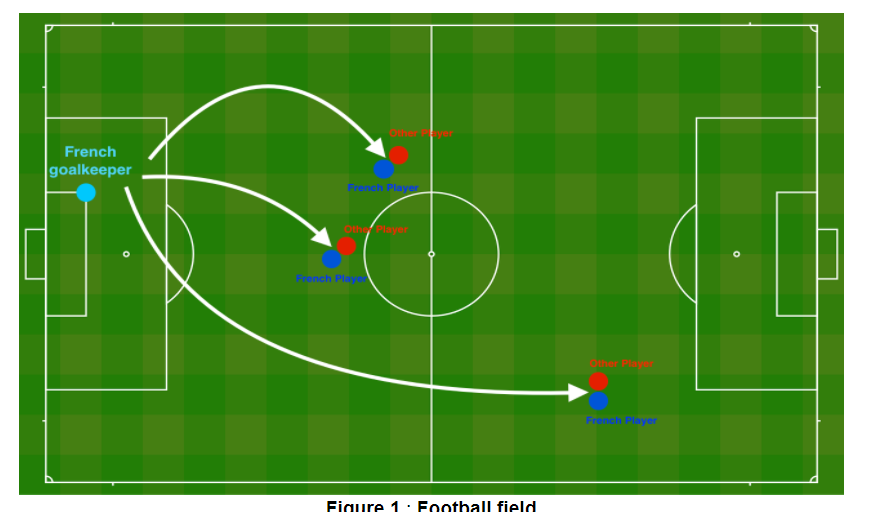






In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
df = pd.read_csv('/content/drive/MyDrive/Data/soccer.csv')

In [7]:
df.head()

,x_1,x_2,Caught
0,-0.158986,0.423977,1
1,-0.347926,0.470760,1
2,-0.504608,0.353801,1
3,-0.596774,0.114035,1
4,-0.518433,-0.172515,1


In [9]:
X = df[['x_1','x_2']].values
y = df['Caught'].values

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


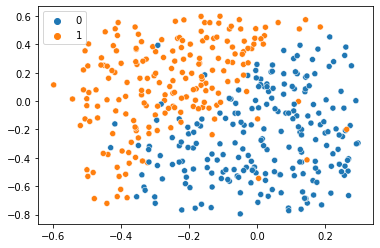

In [10]:
sns.scatterplot(X[:,0],X[:,1],hue = y)

In [193]:
#np.random.seed(7)
X, y = shuffle_examples(X,y)
p_t = 0.7
p_tv = 0.85
X_train, y_train, X_val, y_val, X_test, y_test = split_train_validation_test(X,y,p_t,p_tv)
X_train_scaled, X_train_mean, X_train_std = scale(X_train)

In [227]:
n = [2, 20, 3, 1]
act = [None,'relu','relu','sigmoid']
c = 0.2
epochs = 20000


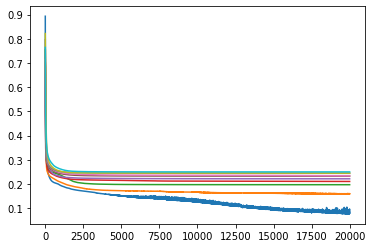

In [228]:
las = np.arange(0,1,0.1)
J = []
for la in las:
  W, b, J_list = steepest_reg(n,act,X_train_scaled,y_train,epochs,c,la)
  plt.plot(J_list)
  y_hat = scale_predict(X_val,X_train_mean,X_train_std,W,b,act)
  J.append(error(y_val,y_hat))




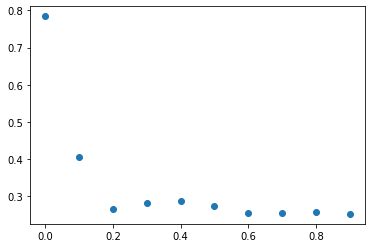

In [229]:
plt.plot(las,J,'o')

In [230]:
W, b, J_list = steepest_reg(n,act,X_train_scaled,y_train,epochs,c,0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in multiply


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


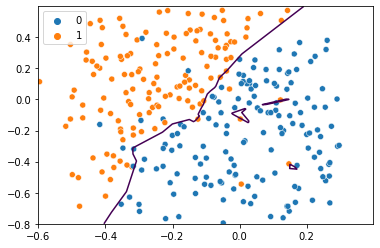

In [231]:
xl,xr,dx,yl,yr,dy = -0.6,0.4,0.001,-0.8,0.6,0.001
decision_boundary(X,y,xl,xr,dx,yl,yr,dy,X_train_mean,X_train_std,W,b,act)

In [232]:
#np.random.seed(7)
W, b, J_list = steepest_reg(n,act,X_train_scaled,y_train,epochs,c,0.2)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


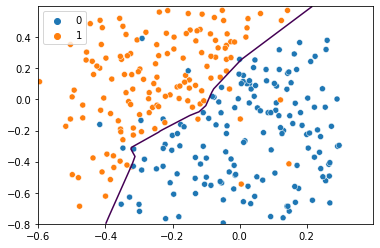

In [233]:
xl,xr,dx,yl,yr,dy = -0.6,0.4,0.001,-0.8,0.6,0.001
decision_boundary(X,y,xl,xr,dx,yl,yr,dy,X_train_mean,X_train_std,W,b,act)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


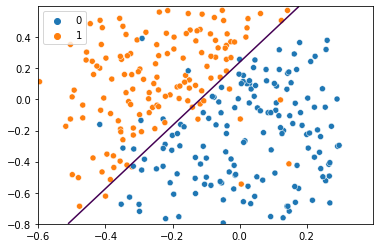

In [213]:
xl,xr,dx,yl,yr,dy = -0.6,0.4,0.001,-0.8,0.6,0.001
decision_boundary(X,y,xl,xr,dx,yl,yr,dy,X_train_mean,X_train_std,W,b,act)